In [2]:
from __future__ import print_function, division

import xgboost as xgb
import numpy as np
import pandas as pd
import time

import pickle
from tqdm import tqdm, tqdm_notebook

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import cross_val_score, KFold, train_test_split, \
                                    StratifiedKFold, RandomizedSearchCV

from sklearn.decomposition import PCA

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, \
                            classification_report, log_loss

from multi_agent_simulator import BiddingAgent, BiddingEnvironment, BidStrategy

from sklearn.utils import resample

import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
pd.set_option('display.max_columns', 100)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Load data

In [25]:
train = pd.read_hdf('preprocessed.h5', 'train')
validation = pd.read_hdf('preprocessed.h5', 'validation')

y_validate = validation['click'].values
X_validate = validation.drop(columns=['click', 'payprice'])

In [3]:
%%time
pre_subsample_size = int(8e5)
np.random.seed(9345)

class0_index = train[train['click'] == 0].index

# take random sample
random_subsample = np.random.choice(
    class0_index, pre_subsample_size, replace=False)
class0_downsampled = train.loc[random_subsample]
class1 = resample(
    train[train['click'] == 1], replace=True, n_samples=int(1e4), random_state=9345)

# combine dataframes
training_data = pd.concat([class0_downsampled, class1])

y_train = training_data['click'].values
X_train = training_data.drop(columns=['click', 'payprice'])

del(train, training_data)
print(X_train.shape)
print(np.bincount(y_train))
print('done')

(810000, 963)
[800000  10000]
done
CPU times: user 18.8 s, sys: 8.87 s, total: 27.6 s
Wall time: 27.7 s


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=2349)

# Train model

In [5]:
%%time
# Create a model for xgboost
pos, neg = np.bincount(y_train)
folds = 3
param_comb = 5

param_dist = {
    'learning_rate': 0.1,
    'max_depth': 10,
    'verbosity': 2,
    'subsample': .8,
    'colsample_bytree': .9,
    'gamma': .3,
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'n_jobs': -1,
    'random_state': 222,
    'n_estimators': 200,
    'scale_pos_weight': neg / pos,
    'eval_metric': ['logloss', 'auc']
}

eval_set = [
    (X_train, y_train),
    (X_test, y_test),
    (X_validate, y_validate)
]

clf = xgb.XGBClassifier(**param_dist)

clf.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=40)

[0]	validation_0-logloss:0.600398	validation_0-auc:0.5	validation_1-logloss:0.600811	validation_1-auc:0.5	validation_2-logloss:0.598318	validation_2-auc:0.5
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 40 rounds.
[1]	validation_0-logloss:0.52465	validation_0-auc:0.5	validation_1-logloss:0.525118	validation_1-auc:0.5	validation_2-logloss:0.520556	validation_2-auc:0.5
[2]	validation_0-logloss:0.462136	validation_0-auc:0.5	validation_1-logloss:0.462139	validation_1-auc:0.5	validation_2-logloss:0.455671	validation_2-auc:0.5
[3]	validation_0-logloss:0.409251	validation_0-auc:0.5	validation_1-logloss:0.409334	validation_1-auc:0.5	validation_2-logloss:0.401061	validation_2-auc:0.5
[4]	validation_0-logloss:0.364249	validation_0-auc:0.5	validation_1-logloss:0.364334	validation_1-auc:0.5	validation_2-logloss:0.354323	validation_2-auc:0.5
[5]	validation_0-logloss:0.326178	validation_0-auc:0.5	vali

In [9]:
y_validate_hat = clf.predict_proba(X_validate)
score = roc_auc_score(y_validate, y_validate_hat[:, 1])

print('ROC AUC score {}'.format(score))

filename = 'XGB_ROC_{:.4f}'.format(score)
pickle.dump(clf, open(filename, "wb"))

print('done')

ROC AUC score 0.8910638937778863
done


# Load best model

In [27]:
clf = pickle.load(open('XGB_ROC_0.8911', "rb"))
pCTR = clf.predict_proba(X_validate)[:, 1]

/Users/davidvanrooij/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Find optimal bidding strategy

In [12]:
environment = BiddingEnvironment(validation)

## Linear

In [32]:
no_click, click = np.bincount(validation['click'])
avgCTR = click / (no_click + click)

bid_range = np.arange(190, 215, 1)

results_linear = {}

# find optimal base_bid
for const in tqdm(bid_range):
    
    agent = BiddingAgent(6250*1000, environment)
    bids = BidStrategy.linear_bidding(pCTR, avgCTR, const)

    agent.simulate(bids)
    results_linear[const] = agent.statistics()
    
results_linear = pd.DataFrame(results_linear).T
print('done')

100%|██████████| 25/25 [01:17<00:00,  3.09s/it]

done


In [34]:
results_linear.sort_values('clicks', ascending=False).head(5)

,CTR,aCPC,aCPM,budget_left,clicks,impressions,items,lost,spend,too_expensive
202,0.001260,35.795402,45.113205,379554.0,164.0,130127.0,303925.0,173798.0,5870446.0,0.0
203,0.001257,35.947091,45.168313,354677.0,164.0,130519.0,303925.0,173406.0,5895323.0,0.0
213,0.001219,37.675915,45.914144,71150.0,164.0,134574.0,303925.0,169351.0,6178850.0,0.0
212,0.001223,37.458555,45.808220,106797.0,164.0,134107.0,303925.0,169818.0,6143203.0,0.0
211,0.001227,37.276177,45.726693,136707.0,164.0,133692.0,303925.0,170233.0,6113293.0,0.0


## ORTB1

In [38]:
%%time

lamda_range = np.linspace(1e-6, 5e-6, num=20)
const_range = np.arange(10, 100, 10)
parameter_grid = [(x,i) for x in const_range for i in lamda_range]

statistics = {}

results_ortb1 = {}

# find optimal parameters
for const, lamda in tqdm(parameter_grid):
    
    index = (const, lamda)
    
    agent = BiddingAgent(6250*1000, environment)
    bids = BidStrategy.ortb1(pCTR, const, lamda)

    agent.simulate(bids)
    results_ortb1[index] = agent.statistics()
    
results_ortb1 = pd.DataFrame(results_ortb1).T
print('done')

100%|██████████| 180/180 [08:14<00:00,  2.61s/it]

done
CPU times: user 8min 13s, sys: 320 ms, total: 8min 14s
Wall time: 8min 14s


In [39]:
results_ortb1.sort_values('clicks', ascending=False).head(5)

,,CTR,aCPC,aCPM,budget_left,clicks,impressions,items,lost,spend,too_expensive
80,0.000001,0.001149,37.763224,43.371863,19068.0,165.0,143663.0,303925.0,160262.0,6230932.0,0.0
70,0.000001,0.001165,36.615598,42.653091,245042.0,164.0,140786.0,303925.0,163139.0,6004958.0,0.0
60,0.000001,0.001189,35.091037,41.731155,530161.0,163.0,137064.0,303925.0,166861.0,5719839.0,0.0
90,0.000001,0.001246,33.424718,41.633074,801771.0,163.0,130863.0,303925.0,173062.0,5448229.0,0.0
50,0.000001,0.001225,33.078463,40.530893,891289.0,162.0,132213.0,303925.0,171712.0,5358711.0,0.0


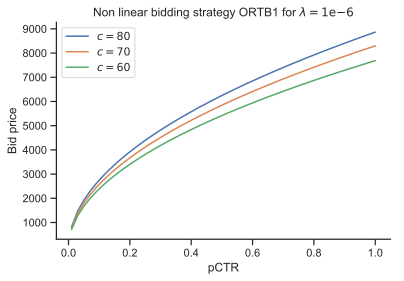

In [22]:
x = np.linspace(1e-2, 1)
y = BidStrategy.ortb1(x, 80, 1e-6)
y2 = BidStrategy.ortb1(x, 70, 1e-6)
y3 = BidStrategy.ortb1(x, 60, 1e-6)

plt.plot(x,y, label='$c=80$')
plt.plot(x, y2, label='$c=70$')
plt.plot(x, y3, label='$c=60$')
sns.despine()
plt.title('Non linear bidding strategy ORTB1 for $\lambda = 1\mathrm{e}{-6}$')
plt.ylabel('Bid price')
plt.xlabel('pCTR')
plt.legend()
plt.savefig('ortb1.eps', dpi=300)
plt.show()

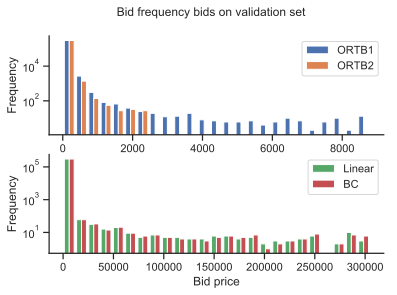

In [84]:
ortb1 = BidStrategy.ortb1(pCTR, 80, 1e-6)
ortb2 = BidStrategy.ortb2(pCTR, 80, 1e-6)
linear = BidStrategy.linear_bidding(pCTR, avgCTR, 202)
bc = BidStrategy.second_price(pCTR, 6250*1000, len(pCTR), 13450000)
# plt.figure(figsize=(14,5)) 
plt.suptitle('Bid frequency bids on validation set')
plt.subplot(211)
plt.hist([ortb1, ortb2], label=['ORTB1','ORTB2'], bins=25)
sns.despine()
plt.ylabel('Frequency')
plt.xlabel('Bid price')
plt.yscale('log')
plt.legend()

plt.subplot(212)
linear = BidStrategy.linear_bidding(pCTR, avgCTR, 202)
bc = BidStrategy.second_price(pCTR, 6250*1000, len(pCTR), 13450000)
plt.hist([linear, bc], label=['Linear','BC'], bins=25, color=['g', 'r'])

sns.despine()
plt.ylabel('Frequency')
plt.xlabel('Bid price')
plt.yscale('log')
plt.legend()
plt.savefig('frequencies.eps', dpi=300)
plt.show()
plt.show()

## ORTB2

In [40]:
%%time

lamda_range = np.linspace(1e-6, 5e-6, num=20)
const_range = np.arange(10, 100, 10)
parameter_grid = [(x,i) for x in const_range for i in lamda_range]

statistics = {}

results_ortb2 = {}

# find optimal parameters
for const, lamda in tqdm(parameter_grid):
    
    index = (const, lamda)
    
    agent = BiddingAgent(6250*1000, environment)
    bids = BidStrategy.ortb2(pCTR, const, lamda)

    agent.simulate(bids)
    results_ortb2[index] = agent.statistics()
    
results_ortb2 = pd.DataFrame(results_ortb2).T
print('done')

100%|██████████| 180/180 [08:42<00:00,  2.88s/it]

done
CPU times: user 8min 41s, sys: 120 ms, total: 8min 42s
Wall time: 8min 42s


In [41]:
results_ortb2.sort_values('clicks', ascending=False).head(5)

,,CTR,aCPC,aCPM,budget_left,clicks,impressions,items,lost,spend,too_expensive
80,0.000001,0.001119,38.109756,42.637087,0.0,164.0,146586.0,303925.0,157152.0,6250000.0,187.0
70,0.000001,0.001142,36.243497,41.381390,342310.0,163.0,142762.0,303925.0,161163.0,5907690.0,0.0
90,0.000002,0.001170,35.960632,42.071294,388417.0,163.0,139325.0,303925.0,164600.0,5861583.0,0.0
80,0.000002,0.001188,34.583407,41.070522,647488.0,162.0,136412.0,303925.0,167513.0,5602512.0,0.0
90,0.000002,0.001242,32.730391,40.664205,980407.0,161.0,129588.0,303925.0,174337.0,5269593.0,0.0


## Budget constrained

In [62]:
B =6250*1000
T = environment.length

const_range = np.linspace(13000000, 13900000, 51)

results_second_price = {}

# find optimal parameters
for const in tqdm(const_range):
    
    agent = BiddingAgent(6250*1000, environment)
    bids = BidStrategy.second_price(pCTR, B, T, const)

    agent.simulate(bids)
    results_second_price[const] = agent.statistics()
    
results_second_price = pd.DataFrame(results_second_price).T
print('done')

100%|██████████| 51/51 [02:36<00:00,  3.03s/it]

done


In [63]:
results_second_price.sort_values('clicks', ascending=False).head(5)

,CTR,aCPC,aCPM,budget_left,clicks,impressions,items,lost,spend,too_expensive
13450000.0,0.001245,36.441384,45.386374,273613.0,164.0,131678.0,303925.0,172247.0,5976387.0,0.0
13684000.0,0.001236,36.844628,45.555096,207481.0,164.0,132642.0,303925.0,171283.0,6042519.0,0.0
13504000.0,0.001244,36.524183,45.422921,260034.0,164.0,131871.0,303925.0,172054.0,5989966.0,0.0
13522000.0,0.001243,36.555159,45.435602,254954.0,164.0,131946.0,303925.0,171979.0,5995046.0,0.0
13540000.0,0.001242,36.583518,45.449151,250303.0,164.0,132009.0,303925.0,171916.0,5999697.0,0.0


# Test submission

In [4]:
test = pd.read_hdf('preprocessed.h5', 'test')
X_test = test.drop(columns=['click', 'payprice'])
pCTR_test = clf.predict_proba(X_test)[:, 1]

bids = BidStrategy.second_price(pCTR_test, 6250*1000, len(X_test), 13684000)

# get bid id's
test_raw = pd.read_csv('../we_data/test.csv')

# export to file
df_bids = pd.DataFrame(
    np.round(bids, 1), index=test_raw['bidid'].values, columns=['bidprice'])
df_bids.index.name = 'bidid'
df_bids = df_bids.reset_index()

file = 'bid_attemnt_XGB_{}.csv'.format(time.strftime('%Y-%m-%d_%H:%M:%S'))
df_bids.to_csv(file, index=False)